In [1]:
#@title Import Dependencies
import  os,shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import glob

from keras import backend as K
from keras.models import load_model
from keras import metrics


from tqdm import tqdm_notebook as tqdm
from PIL import Image
from skimage.transform import resize

from keras.models import Input, Model
from keras.layers import BatchNormalization, LeakyReLU, Conv2D, Dense, \
                         Flatten, Add, PReLU, Conv2DTranspose, Lambda, UpSampling2D                    
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
ImageList = glob.glob('C:/Users/user/Downloads/Compressed/sample/train'+'/*')

In [3]:
#@title Resizing the image
img_list, img_low_list = [], []
for i in ImageList:
    BaseImage = cv2.imread(i)
    Height, Width = 256, 256
    BaseImage = cv2.resize(BaseImage,dsize=(256,256))
    HighResolutionImage = BaseImage.copy()
    temp= cv2.resize(BaseImage,dsize=(64,64), interpolation = cv2.INTER_CUBIC)
    LowResolutionImage = cv2.resize(temp,dsize=(128,128), interpolation = cv2.INTER_CUBIC)
    
    img_list.append(HighResolutionImage)
    img_low_list.append(LowResolutionImage)
    

high_reso_imgs = np.array(img_list)
low_reso_imgs = np.array(img_low_list)

In [4]:
#@title Creating the model
class new_model():
  # Implementation of SRGAN from paper:
  # https://arxiv.org/abs/1609.04802
    def __init__(self,lr_height = 128,lr_width = 128,channels = 3,
              upscale_factor = 2, generator_lr = 1e-4, discriminator_lr = 1e-4, gan_lr = 1e-4):
        self.height_low_reso = lr_height
        self.width_low_reso = lr_width

        if upscale_factor % 2 != 0:
            raise ValueError('Upscale factor is invalid, must be product of 2')

        self.upscale_factor = upscale_factor
        self.height_high_reso = self.height_low_reso * self.upscale_factor
        self.width_high_reso = self.width_low_reso * self.upscale_factor

        self.channels = channels
        self.shape_low_reso = (self.height_low_reso,self.width_low_reso,self.channels)
        self.shape_high_reso = (self.height_high_reso,self.width_high_reso,self.channels)

        self.samples = high_reso_imgs.shape[0]

        opti_generator = Adam(generator_lr,0.9)
        opti_discriminator = Adam(discriminator_lr,0.9)
        opti_gan = Adam(gan_lr,0.9) 

        self.vgg = self.bulid_vgg()

        self.discriminator = self.build_discriminator(opti_discriminator)
        self.discriminator.trainable = False
        self.generator = self.build_generator(opti_generator)
        self.srgan = self.build_srgan(opti_gan)
    

    def save_GAN_Model(self,epoch):
        self.srgan.save_weights('srgan_weights_epoch_%d.h5' % epoch)
        

    def plotLosses(self,dlosses,glosses,epo):
        fig, ax1 = plt.subplots(figsize = (10,12))
        color = 'tab:blue'
        ax1.plot(dlosses,color = color, label = 'Dis loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Dis loss', color = color)
        ax1.tick_params('y',color = color)
        color = 'tab:green'
        ax2 = ax1.twinx()
        ax2.plot(glosses, color = color, label = 'Gen loss')
        ax2.set_ylabel('Gen loss', color = color)
        ax2.tick_params('y', color = color)
        plt.title('Discriminator & Generator Losses')
        plt.savefig('Losses_%d.png' % epo)
        plt.show()

    def gen_pipeline(self, batch_size = 4):
        while(1):
            indx_high = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
            
            indx_low = np.random.randint(0,low_reso_imgs.shape[0]-1,batch_size)
            
            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
            
            fake = np.zeros((batch_size,) + self.discriminator.output_shape[1:])
            
            norm_hr = high_reso_imgs[indx_high]/127.5-1
            norm_lr = low_reso_imgs[indx_low]/127.5 -1
            yield(norm_hr,real,norm_lr,fake)
            
    def vgg_pipeline(self, batch_size = 4):
        
        while(1):
            indx = np.random.randint(0,high_reso_imgs.shape[0]-1,batch_size)
            real = np.ones((batch_size,) + self.discriminator.output_shape[1:])
            norm_hr = high_reso_imgs[indx]/127.5-1
            norm_lr = low_reso_imgs[indx]/127.5 -1
            yield(norm_hr,norm_lr,real)
            
      
    def bulid_vgg(self):
        
        vgg = VGG19(weights = "imagenet")
#       vgg.summary()
        vgg.outputs = [vgg.layers[9].output]
        img = Input(shape = self.shape_high_reso)
        img_features = vgg(img)
        vgg_model = Model(img, img_features)
#        for layer in vgg_model.layers:
#             layer.trainable = False
        vgg_model.compile(loss = 'mse', optimizer = Adam(0.0002,0.5),
                         metrics =['acc'])
        return vgg_model


    def residual_block(self,input_layer):
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(input_layer)
        x = BatchNormalization(momentum=0.8)(x)
        x = PReLU()(x)
        x = Conv2D(filters = 64, kernel_size = 3, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Add()([input_layer,x])

    def disc_block(self,layer, n_filters, batch_norm = True):
        x = Conv2D(filters = n_filters, kernel_size = 3, padding = 'same')(layer)
        if batch_norm:
            x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters = n_filters, kernel_size = 3,
                   strides=2, padding = 'same')(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU(alpha=0.2)(x)
        return x

    def Upsample_Block(self,x_in):
        x = Conv2D(filters = 256, kernel_size=3, padding='same')(x_in)
        x = self.SubpixelConv2D(2)(x)
        return PReLU()(x)
      
    def SubpixelConv2D(self,scale):
        return Lambda(lambda x: tf.nn.depth_to_space(x, scale))
    
        
    

    def myfilter(self,shape,dtype=np.uint8):
        
        k=np.zeros(shape)
    
        k[:, :, 0, 0] = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
        k[:, :, 1, 1] = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
        k[:, :, 2, 2] = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
        
        return K.variable(k,dtype=dtype)
    
  
    def build_generator(self,opti_generator,n_blocks = 8):
        input_layer = Input(self.shape_low_reso)
        
        first_layer = Conv2D(filters = 64, kernel_size = 9,
                             padding = 'same')(input_layer)
        
        first_layer = PReLU()(first_layer)
        
        residual_blocks = self.residual_block(first_layer)
        
        for _ in range(n_blocks-1):
            residual_blocks = self.residual_block(residual_blocks)

        #output_residual = Conv2D(filters = 64, kernel_size = 3,padding = 'same')(residual_blocks)
        
        #VDSR
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(residual_blocks)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        processing = PReLU()(processing)
        processing = Conv2D(1, (3, 3), padding='same', kernel_initializer='he_normal')(processing)
        Residual = processing
        
        output_residual = BatchNormalization(momentum=0.8)(Residual)
        
        
        output_residual = Add()([output_residual,first_layer])
        
        #sharpenning layer
        sharpen=Conv2D(filters=3, kernel_size = 3, kernel_initializer=self.myfilter
                       ,strides=1, padding='same',activation='tanh' ,trainable=False)(output_residual)
    
               
        upsample_layer = self.Upsample_Block(sharpen)
        
        #for _ in range(self.upscale_factor//2-1):
         #   upsample_layer =  self.Upsample_Block(upsample_layer)
            
            
            
        ddd=Conv2D(filters=16,kernel_size=3,padding='same',strides=1)(upsample_layer)
        ddd=PReLU()(ddd)
    
            
        gen_output = Conv2D(filters = 3, kernel_size = 5,
                            padding = 'same', activation = 'tanh')(ddd)

        gen_model = Model(inputs = input_layer, outputs = gen_output)
        gen_model.compile(loss = 'binary_crossentropy', optimizer = opti_generator)

        return gen_model

    def build_discriminator(self,opti_discriminator,n_blocks = 3, n_filters = 64):
        input_layer = Input(self.shape_high_reso)
        discriminator_blocks = self.disc_block(input_layer,n_filters,False)
        for i in range(n_blocks):
            discriminator_blocks = self.disc_block(discriminator_blocks, 
                                             n_filters = (i+1)*2*n_filters)
        
        #f_layer = GlobalAveragePooling2D()(discriminator_blocks)
        f_layer = Dense(units = 1024)(discriminator_blocks)
        f_layer = LeakyReLU(alpha=0.2)(f_layer)
        dis_output = Dense(units = 1, activation = 'sigmoid')(f_layer)
        disc_model = Model(inputs = input_layer, outputs = dis_output)
        disc_model.compile(loss = 'mse', optimizer = opti_discriminator,
                          metrics = ['accuracy'])

        return disc_model

    def build_srgan(self,optimizer):
        dis_input = Input(self.shape_high_reso)
        gen_input = Input(self.shape_low_reso)

        generated_high_reso = self.generator(gen_input)
        generated_features = self.vgg(generated_high_reso)
        generator_valid = self.discriminator(generated_high_reso)


        gan_model = Model(inputs = [gen_input, dis_input], 
                          outputs = [generator_valid, generated_features])
        
        for l in gan_model.layers[-1].layers[-1].layers:
            l.trainable=False
        
        gan_model.compile(loss = ['binary_crossentropy','mse'], loss_weights = [1e-2,1], optimizer = 'adam')
        gan_model.summary()
        
        return gan_model



    def train(self, epochs, save_interval = 10, batch_size = 4):
        pipeline = self.gen_pipeline(batch_size)
        vgg_pipeline = self.vgg_pipeline(batch_size)

        batch_count = self.samples // batch_size
        dlosses = []
        glosses = []
        for epo in range(1,epochs+1):
            print ('-'*15,'Epoch %d' % epo, '-'*15)
            for _ in tqdm(range(batch_count)):

                ##########################

                # Train the Discriminator

                ##########################

                # Generate Batch
                hr_imgs, real, lr_imgs, fake = next(pipeline)

                # Generate high resolution photos from low resolution photos
                generated_hr_imags = self.generator.predict(lr_imgs)

                # Train the discriminator 
                real_dis_loss = self.discriminator.train_on_batch(hr_imgs,real)
                fake_dis_loss = self.discriminator.train_on_batch(generated_hr_imags,fake)
                dis_loss = (0.5*np.add(real_dis_loss,fake_dis_loss))

                ##########################

                # Train the Generator

                ##########################

                #Generate Batch
                hr_imgs, lr_imgs, real = next(vgg_pipeline)

                # Extract ground truth using VGG model
                img_features = self.vgg.predict(hr_imgs)

                gan_loss = self.srgan.train_on_batch([lr_imgs,hr_imgs], [real, img_features])


            
            dlosses.append(gan_loss[1])
            glosses.append(gan_loss[0])
            print('\n',dlosses[-1],glosses[-1])


In [5]:
def plot_predict(low_reso_imgs,high_reso_imgs,srgan_model,n_imgs = 4):
    plt.figure(figsize = (12,12))
    plt.tight_layout()
    for i in range(0,n_imgs*3,3):
        idx = np.random.randint(0,low_reso_imgs.shape[0]-1)
        plt.subplot(n_imgs,3,i+1)
        plt.imshow(high_reso_imgs[idx])
        plt.grid('off')
        plt.axis('off')
        plt.title('Source')
        plt.subplot(n_imgs,3,i+2)
        plt.imshow(cv2.resize(low_reso_imgs[idx],(256,256),
                          interpolation = cv2.INTER_CUBIC))
        plt.grid('off')
        plt.axis('off')
        plt.title('X4 (bicubic)')
        
        img = srgan_model.generator.predict(np.expand_dims(low_reso_imgs[idx], axis = 0) / 127.5 - 1)
        img_unnorm = (img+1) * 127.5
        plt.subplot(n_imgs,3,i+3)
        plt.imshow(np.squeeze(img_unnorm, axis = 0).astype(np.uint8))
        plt.grid('off')
        plt.axis('off')
        plt.title('SRGAN')
        
    plt.savefig('predicted.png')

In [6]:
model= new_model()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 256, 256, 3)  35935115    input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16, 16, 1)    3759681     model_3[1][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 64, 64, 256)  143667240   model_3[1][0]                    
Total params: 183,362,036
Trainable params: 35,931,334
Non-trainable params: 147,430,702
___

In [7]:
model.generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 64) 15616       input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 128, 128, 64) 1048576     conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 64) 36928       p_re_lu_1[0][0]                  
____________________________________________________________________________________________

batch_normalization_19 (BatchNo (None, 128, 128, 64) 256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
add_6 (Add)                     (None, 128, 128, 64) 0           add_5[0][0]                      
                                                                 batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 128, 128, 64) 36928       add_6[0][0]                      
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 128, 128, 64) 256         conv2d_22[0][0]                  
__________________________________________________________________________________________________
p_re_lu_8 (PReLU)               (None, 128, 128, 64) 1048576     batch_normalization_20[0][0]     
__________

__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 64) 36928       p_re_lu_22[0][0]                 
__________________________________________________________________________________________________
p_re_lu_23 (PReLU)              (None, 128, 128, 64) 1048576     conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 128, 128, 64) 36928       p_re_lu_23[0][0]                 
__________________________________________________________________________________________________
p_re_lu_24 (PReLU)              (None, 128, 128, 64) 1048576     conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 128, 128, 64) 36928       p_re_lu_24[0][0]                 
__________

In [8]:
model.discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     7385

E:\Anaconda\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Total params: 7,516,162
Trainable params: 3,756,481
Non-trainable params: 3,759,681
_________________________________________________________________


In [11]:
#model.train(6 ,save_interval=6,batch_size=4)

--------------- Epoch 1 ---------------


E:\Anaconda\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
E:\Anaconda\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




 3.397498 7.084086
--------------- Epoch 2 ---------------




 3.7523317 4.6475763
--------------- Epoch 3 ---------------




 3.2226484 4.1971064
--------------- Epoch 4 ---------------




 4.1372333 5.5053062
--------------- Epoch 5 ---------------




 3.832655 4.11062
--------------- Epoch 6 ---------------




 4.1790686 4.035675


In [12]:
#model.save_GAN_Model(6)

In [9]:
testList=glob.glob('C:/Users/user/Downloads/Compressed/sample/test'+'/*')

In [10]:
test_list, test_low_list = [], []
for i in testList:
    BaseImage = cv2.imread(i)
    Height, Width = 256, 256
    BaseImage = cv2.resize(BaseImage,dsize=(256,256))
    HighResolutionImage = BaseImage.copy()
    temp= cv2.resize(BaseImage,dsize=(64,64), interpolation = cv2.INTER_CUBIC)
    LowResolutionImage = cv2.resize(temp,dsize=(128,128), interpolation = cv2.INTER_CUBIC)
    
    test_list.append(HighResolutionImage)
    test_low_list.append(LowResolutionImage)
    

test_hr_imgs = np.array(test_list)
test_lr_imgs = np.array(test_low_list)

In [11]:
model.srgan.load_weights("C:/Users/user/Desktop/AI project 2/superresolution/proposed model/new_model_weights_epoch_6.h5")

In [12]:
pred_list=[]
for img in test_lr_imgs:
    temp= model.generator.predict(np.expand_dims(img, axis = 0) / 127.5 - 1)
    pred=(temp+ 1) * 127.5
    pred_list.append(np.squeeze(pred, axis = 0).astype(np.uint8))

pred_list=np.array(pred_list)

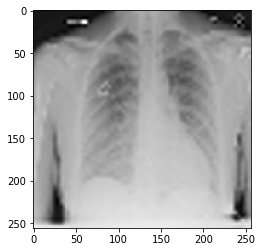

In [13]:
plt.imshow(cv2.resize(test_lr_imgs[77],dsize=(256,256),interpolation =cv2.INTER_CUBIC))

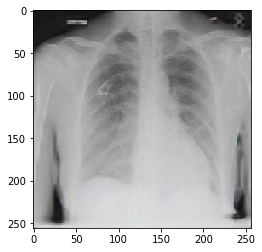

In [14]:
plt.imshow(pred_list[77])

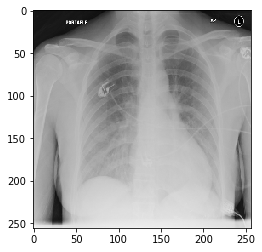

In [15]:
plt.imshow(test_hr_imgs[77])

In [17]:
import sewar

In [18]:
uqi=0
for i in range(150):
    uqi+= sewar.full_ref.uqi(test_hr_imgs[i],pred_list[i])
uqi/=150

uqi

0.9579706998410747

In [19]:
psnr=0
for i in range(150):
    psnr+= sewar.full_ref.psnr(test_hr_imgs[i],pred_list[i])
psnr/=150

psnr

28.431383785646734

In [20]:
ssim=0
for i in range(150):
    ssim+= sewar.full_ref.ssim(test_hr_imgs[i],pred_list[i])[0]
ssim/=150

ssim

0.828199885880621

In [21]:
ms_ssim=0
for i in range(150):
    ms_ssim+= sewar.full_ref.msssim(test_hr_imgs[i],pred_list[i])
ms_ssim/=150

ms_ssim

(0.9611327770942469+0j)